In [1]:
import gym
import gymnasium as gym
from gymnasium import Env, spaces
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.express as px
import random
import networkx as nx
import matplotlib.patches as mpatches






c:\Users\tass\anaconda3\Lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



In [2]:
# Configuração dos drones e ambiente
num_drones = 3
limite_y = 80
limite_x = 100
alcance_comunicacao_jammer = 25
alcance_comunicacao_nos = 5000
B_Hz = 2.4e9
posicoes = np.array([[16, 30], [18, 48], [44, 15]])
posicao_jammer = np.array([38, 50])

Ptx_dBm = 20
f = 2.4e9
d0 = 1
gamma = 2
sigma = 0
c = 3e8
lambda_m = c / f
L0 = 30
potencia_jammer_dBm = 100


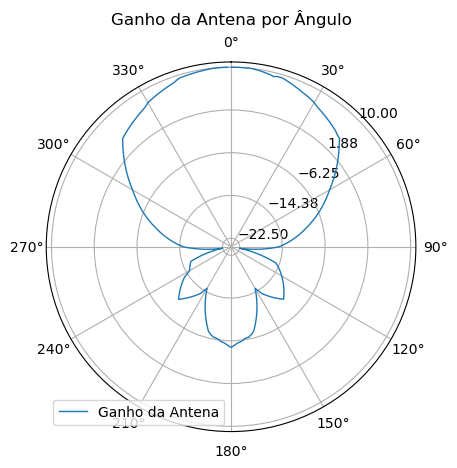

In [3]:
# Ler o arquivo de ganhos para criar uma tabela de busca
ganhos_df = pd.read_csv('ganhos.csv')

angulos = np.deg2rad(ganhos_df['angulo'])  # Converter graus para radianos
ganhos = ganhos_df['ganho']

# Criar um gráfico polar
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angulos, ganhos, linestyle='-', linewidth=1, label='Ganho da Antena')

# Ajustar o layout
ax.set_theta_zero_location('N')  # Configurar a direção Norte como o topo do gráfico
ax.set_theta_direction(-1)  # Configurar a direção dos ângulos para sentido horário
ax.set_rmax(max(ganhos) + 1)  # Ajustar o raio máximo para melhor visualização
ax.set_rticks(np.linspace(min(ganhos), max(ganhos), num=5))  # Definir os ticks para o raio
ax.set_rlabel_position(45)  # Posicionar os labels do raio

# Configurar os ticks para o ângulo
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Definir marcas de ângulo a cada 30 graus

# Adicionar legenda e título
ax.legend()
ax.set_title('Ganho da Antena por Ângulo', va='bottom')

# Mostrar o gráfico
plt.show()

In [4]:
# Funções utilitárias
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def angulo_entre_nos(pos1, direcao_antena, pos2):
    delta_x = pos2[0] - pos1[0]
    delta_y = pos2[1] - pos1[1]
    direcao_vetor_rad = np.arctan2(delta_y, delta_x)
    direcao_vetor_deg = np.degrees(direcao_vetor_rad)
    angulo = (direcao_vetor_deg - direcao_antena) % 360
    return round(angulo)

def busca_ganhos(angulo):
    angulo_ajustado = int(round(angulo))
    if angulo_ajustado == 360:
        angulo_ajustado = 0
    ganho = ganhos_df.loc[ganhos_df['angulo'] == angulo_ajustado, 'ganho'].iloc[0]
    return ganho

def calcula_ganhos(posicoes, direcoes_antena, indice_transmissor, indice_receptor, ganhos_df):
    pos1 = posicoes[indice_transmissor]
    pos2 = posicoes[indice_receptor]
    direcao_antena1 = direcoes_antena[indice_transmissor]
    direcao_antena2 = direcoes_antena[indice_receptor]
    angulo_transmissao = angulo_entre_nos(pos1, direcao_antena1, pos2)
    angulo_rececao = angulo_entre_nos(pos2, direcao_antena2, pos1)
    ganho_transmissao = busca_ganhos(angulo_transmissao)
    ganho_rececao = busca_ganhos(angulo_rececao)
    return ganho_transmissao, ganho_rececao

def calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m):
    if d > 0:
        L = L0 + 10 * gamma * np.log10(d / d0) + np.random.normal(0, sigma)
    else:
        L = L0
    Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - L
    return Prx_dBm

def calcula_potencia_jammer(pos_drone, direcao_antena_drone, pos_jammer, potencia_jammer_dBm, ganhos_df):
    d = distancia(pos_drone, pos_jammer)
    angulo_entre_drone_e_jammer = angulo_entre_nos(pos_drone, direcao_antena_drone, pos_jammer)
    ganho_drone_para_jammer = busca_ganhos(angulo_entre_drone_e_jammer)
    L = (4 * np.pi * d / lambda_m) ** 2
    potencia_jammer_recebida_dBm = potencia_jammer_dBm + ganho_drone_para_jammer - 10 * np.log10(L)
    return potencia_jammer_recebida_dBm

def calcula_capacidade(potencia_sinal_dBm, potencia_ruido_dBm):
    potencia_sinal_W = 10 ** (potencia_sinal_dBm / 10) / 1000
    potencia_ruido_W = 10 ** (potencia_ruido_dBm / 10) / 1000
    snr = potencia_sinal_W / potencia_ruido_W
    capacidade = B_Hz * np.log2(1 + snr)
    return capacidade / 1e3

DRL

In [5]:
seed=0


# Definindo valores de direção discretos (10 valores)
direcoes_discretas = np.linspace(0, 360, 10, endpoint=False)



class UAVCommunicationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=num_drones, area_size=(100, 100)):
        super().__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.posicoes = posicoes
        self.posicao_jammer = posicao_jammer
        self.ultimo_info = {}

        # Define o espaço de ação como direções para cada drone
        # self.action_space = spaces.MultiDiscrete([360] * num_uavs)
        # self.observation_space = spaces.MultiDiscrete([360] * num_uavs)
        # self.direcoes_antena = np.random.uniform(0, 360, size=num_uavs)

        
        
        # Define o espaço de ação como direções discretas para cada drone
        self.action_space = spaces.MultiDiscrete([len(direcoes_discretas)] * num_uavs)
        self.observation_space = spaces.MultiDiscrete([360] * num_uavs)
        self.direcoes_antena = np.random.choice(direcoes_discretas, size=num_uavs)

        
        
    def step(self, action):
        # self.direcoes_antena = np.array(action)
        self.direcoes_antena = direcoes_discretas[action]
        
        total_capacidades = 0
        capacidade_media=0
        capacidades_por_link = []
        
        # assert len(action) == self.num_uavs

        # Iterar por todos os drones para calcular a capacidade entre eles
        for i in range(self.posicoes.shape[0]):
            for j in range(self.posicoes.shape[0]):
                if i != j:
                    # Calcular a distância entre os dois drones
                    d = distancia(posicoes[i], posicoes[j])
                    # Calcular os ganhos de transmissão e recepção
                    ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, self.direcoes_antena, i, j, ganhos_df)
                    # Calcular a potência do sinal recebido usando a equação de Friis
                    potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
                    potencia_ruido = calcula_potencia_jammer(posicoes[j], self.direcoes_antena[j], posicao_jammer, potencia_jammer_dBm, ganhos_df)
                    capacidade_canal=calcula_capacidade(potencia_recebida,potencia_ruido)
                    capacidades_por_link.append(capacidade_canal)
                    total_capacidades += capacidade_canal

        # Recompensa é a soma das capacidades de todos os links
        capacidade_media=np.mean(capacidades_por_link)
        recompensa = capacidade_media
        capacidades_por_link = [round(capacidade, 3) for capacidade in capacidades_por_link]
        capacidade_media = round(capacidade_media, 3)
        
        capacidade_matriz = np.zeros((num_drones, num_drones))
        link_index = 0
        

        for i in range(num_drones):
            for j in range(num_drones):
                if i != j:
                    capacidade_matriz[i, j] = capacidades_por_link[link_index]
                    link_index += 1

        
        # Informação adicional a ser retornada
        info = {
            'Capacidade média [Kbps]': capacidade_media,
            'Capacidades_por_link [Kbps]': capacidades_por_link,
            'Matriz de Capacidades [Kbps]': capacidade_matriz
            
        }
        terminated = False
        truncated = False
        done=False

        # Retorna a observação, recompensa, indicador de fim de episódio e informações adicionais
        return np.array(self.direcoes_antena), recompensa,terminated,truncated, info
    
    def render(self, mode='human'):
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(9, 4))

        # Desenha os drones no gráfico
        for i, pos in enumerate(self.posicoes):
            ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone' if i == 0 else "")
            ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

        # Desenha as setas para a direção das antenas
        comprimento_seta = 5  # Comprimento das setas
        for i, direcao in enumerate(self.direcoes_antena):
            direcao_rad = np.radians(direcao)  # Converte para radianos
            dx = comprimento_seta * np.cos(direcao_rad)  # Deslocamento em x
            dy = comprimento_seta * np.sin(direcao_rad)  # Deslocamento em y
            
            ax.arrow(
                self.posicoes[i][0], self.posicoes[i][1], 
                dx, dy, 
                head_width=2, head_length=2, fc='b', ec='b'
            )  # Seta azul para indicar a direção da antena

        # Desenha o jammer
        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

        # Configurações finais do gráfico
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        plt.title('Direções das Antenas UAV')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

        plt.show()
        
    def reset(self,seed=None):
        super().reset()
        self.direcoes_antena = np.random.uniform(0, 360, size=self.num_uavs)
        assert len(self.direcoes_antena) == self.num_uavs, "Número incorreto de direções"
        obs = np.array(self.direcoes_antena)
        return obs, {}

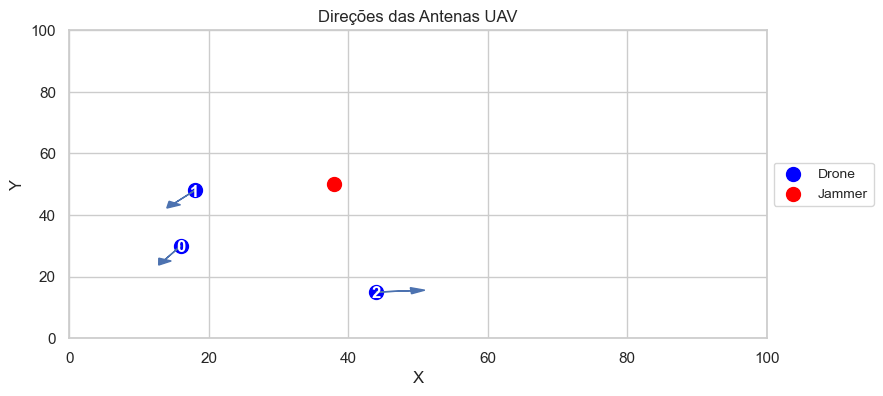

Direções Estabelecidas:

[243 235   5]

Capacidade Média [Kbps]:
1.401

Capacidade por Link [Kbps]:
[2.688, 0.05, 5.49, 0.167, 0.005, 0.009]

Matriz de Capacidades [Kbps]:
	0.00 2.69 0.05
	5.49 0.00 0.17
	0.01 0.01 0.00


In [6]:
env = UAVCommunicationEnv()

state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Exemplo: escolha uma ação aleatoriamente
    state, reward,terminated,truncated, info = env.step(action)
    env.render()  # Chame render a cada passo para visualizar
    
    # print(info)
    
    print('Direções Estabelecidas:\n')
    print(state)
    
    if 'Capacidade média [Kbps]' in info:
        print("\nCapacidade Média [Kbps]:")
        capacidade_media=info['Capacidade média [Kbps]']
        print(capacidade_media)
    
    if 'Capacidades_por_link [Kbps]' in info:
        print("\nCapacidade por Link [Kbps]:")
        capacidade_por_link=info['Capacidades_por_link [Kbps]']
        print(capacidade_por_link)
    
    
    if 'Matriz de Capacidades [Kbps]' in info:
        print("\nMatriz de Capacidades [Kbps]:")
        capacidade_matriz = info['Matriz de Capacidades [Kbps]']
        print('\n'.join(['\t' + ' '.join(f"{item:.2f}" for item in row) for row in capacidade_matriz]))
    else:
        print("Chave 'Matriz de Capacidades[Kbps]' não encontrada em info.")
    done=True

In [7]:


class StopTrainingOnNoImprovement(BaseCallback):
    def __init__(self, min_evals=5, min_diff=1e-3, verbose=0):
        super(StopTrainingOnNoImprovement, self).__init__(verbose)
        self.min_evals = min_evals
        self.min_diff = min_diff
        self.best_mean_reward = -np.inf
        self.no_improvement_evals = 0
    
    def _on_step(self):
        if self.n_calls % self.min_evals == 0:
            rewards = self.locals['rewards']
            if len(rewards) >= self.min_evals:
                mean_reward = np.mean(rewards[-self.min_evals:])
                if mean_reward - self.best_mean_reward < self.min_diff:
                    self.no_improvement_evals += 1
                else:
                    self.no_improvement_evals = 0
                    self.best_mean_reward = mean_reward
                if self.no_improvement_evals >= self.min_evals:
                    print(f"No significant improvement for {self.no_improvement_evals} evaluations. Stopping training.")
                    return False
        return True

class LoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(LoggingCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # Esta função será chamada a cada passo
        if self.n_calls % 1000 == 0:
            fps = self.logger.name_to_value.get("time/fps", "N/A")
            iterations = self.logger.name_to_value.get("time/iterations", "N/A")
            time_elapsed = self.logger.name_to_value.get("time/time_elapsed", "N/A")
            total_timesteps = self.logger.name_to_value.get("time/total_timesteps", "N/A")
            print("-----------------------------")
            print(f"| time/              |      |")
            print(f"|    fps             | {fps} |")
            print(f"|    iterations      | {iterations} |")
            print(f"|    time_elapsed    | {time_elapsed} |")
            print(f"|    total_timesteps | {total_timesteps} |")
            print("-----------------------------")
        return True
    
    
# Verificação do ambiente
env = UAVCommunicationEnv()
# check_env(env)

# Envolvendo o ambiente com Monitor para registrar estatísticas
env = Monitor(env)

# Envolvendo o ambiente em DummyVecEnv
env = DummyVecEnv([lambda: env])

# Treinamento do modelo PPO com callback
model = PPO("MlpPolicy", env, verbose=1, n_steps=512)  # Por exemplo, reduzindo para 512 passos
stop_callback = StopTrainingOnNoImprovement(min_evals=5, min_diff=0.01)
logging_callback = LoggingCallback()
model.learn(total_timesteps=10000, callback=[stop_callback, logging_callback])

# Avaliação do modelo para encontrar o melhor episódio
best_reward = -np.inf
best_obs = None
best_info = None

for _ in range(5):
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated,info = env.step(action)
        total_reward += reward
        if terminated:
            done = True
    if total_reward > best_reward:
        best_reward = total_reward
        best_obs = obs
        best_info = info

# Renderizar a melhor solução
env.render_mode = 'human'
env.reset(seed=seed)
env.direcoes_antena = best_obs  # Definindo a melhor direção das antenas
env.render()
print("Melhor Resultado Direções:", best_obs)
print("Melhor Resultado Info:", best_info)

Using cpu device
----------------------------
| time/              |     |
|    fps             | 240 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
-----------------------------
| time/              |      |
|    fps             | N/A |
|    iterations      | N/A |
|    time_elapsed    | N/A |
|    total_timesteps | N/A |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 216           |
|    iterations           | 2             |
|    time_elapsed         | 4             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00010230474 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -17.7         |
|    explained_variance   | 3.22e-06      |
|    learning_rate        | 0.0003        |
| 

KeyboardInterrupt: 